In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import torch

In [ ]:
emotions  = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotions['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
emotions.set_format(type="pandas")

In [ ]:
df = emotions["train"][:]

df_val = emotions["validation"][:]
df_test = emotions["test"][:]

In [ ]:
df.iloc[5]


text     ive been feeling a little burdened lately wasn...
label                                                    0
Name: 5, dtype: object

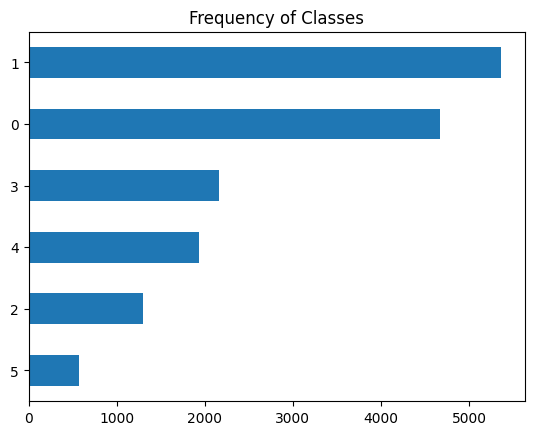

In [ ]:
import matplotlib.pyplot as plt

df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()




In [ ]:
from torch.utils.data import Dataset

In [ ]:
import torch

In [ ]:
import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    'distilbert-base-uncased'
)

In [ ]:
train_texts = df['text'].values
train_labels = df['label'].values
valid_texts = df_val['text'].values
test_texts = df_test['text'].values
valid_labels = df_val['label'].values
test_labels = df_test['label'].values

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts),truncation = True, padding = True)
test_encodings = tokenizer(list(test_texts), truncation = True, padding = True)


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, encodings,labels):
        self.encoding = encodings
        self.labels = labels

    def __getitem__(self,idx):
        item =  {key:torch.tensor(val[idx]) for key,val in self.encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)



In [ ]:
train_dataset = EmotionDataset(train_encodings,train_labels)
valid_dataset = EmotionDataset(valid_encodings,valid_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels = 6
)
model.to(DEVICE)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
model.train()
optim = torch.optim.Adam(model.parameters(), lr=5e-5)


In [ ]:
def compute_accuracy(model, data_loader,device):
    with torch.no_grad():
        correct_pred, num_examples = 0,0
        for batch_idx, batch in enumerate(data_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask = attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

    return correct_pred.float()/num_examples * 100




In [ ]:
import time

In [ ]:
start_time = time.time()
NUM_EPOCHS = 20


In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch  in enumerate(train_loader):

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

        loss, logits = outputs['loss'], outputs['logits']

        optim.zero_grad()
        loss.backward()
        optim.step()

        if not batch_idx % 250:
            print(f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d}'
                f' | Batch'
                f'{batch_idx:04d}/'
                f'{len(train_loader):04d} | '
                f'Loss: {loss:.4f}')

    model.eval()

    with torch.set_grad_enabled(False):
        print(f'Training accuracy: '
         f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
         f'\nValid accuracy: '
         f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

    print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
    print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 0001/0020 | Batch0000/1000 | Loss: 1.7383
Epoch: 0001/0020 | Batch0250/1000 | Loss: 0.1959
Epoch: 0001/0020 | Batch0500/1000 | Loss: 0.0480
Epoch: 0001/0020 | Batch0750/1000 | Loss: 0.2769
Training accuracy: 94.50%
Valid accuracy: 93.45%
Time elapsed: 2.75 min
Total Training Time: 2.75 min
Test accuracy: 92.85%
Epoch: 0002/0020 | Batch0000/1000 | Loss: 0.0945
Epoch: 0002/0020 | Batch0250/1000 | Loss: 0.4953
Epoch: 0002/0020 | Batch0500/1000 | Loss: 0.1205
Epoch: 0002/0020 | Batch0750/1000 | Loss: 0.0076
Training accuracy: 94.81%
Valid accuracy: 92.50%
Time elapsed: 5.61 min
Total Training Time: 5.61 min
Test accuracy: 92.40%
Epoch: 0003/0020 | Batch0000/1000 | Loss: 0.0074
Epoch: 0003/0020 | Batch0250/1000 | Loss: 0.1999
Epoch: 0003/0020 | Batch0500/1000 | Loss: 0.5534
Epoch: 0003/0020 | Batch0750/1000 | Loss: 0.1089
Training accuracy: 95.74%
Valid accuracy: 93.55%
Time elapsed: 8.47 min
Total Training Time: 8.47 min
Test accuracy: 92.50%
Epoch: 0004/0020 | Batch0000/1000 | Loss

In [ ]:
def compute_accuracy(model, data_loader,device):
    with torch.no_grad():
        correct_pred, num_examples = 0,0
        for batch_idx, batch in enumerate(data_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask = attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

    return correct_pred.float()/num_examples * 100